# Исследование рынка видео-игр

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам необходимо выявить определяющие успешность игры закономерности. На основании этих данных мы выберем наиболее перспективные платформы для разработки игр в будущем.
Перед нами данные до 2016 года, соответсвенно, наше исследование должно помочь сделать корректный прогноз рынка на 2017.

Помимо анализа рынка нам предстоит статистическими методами проверить 2 гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action и Sports одинаковые.

## Первичный анализ данных

In [1]:
import pandas as pd
import re
from scipy import stats as st
import matplotlib.pyplot as plt 

In [2]:
data = pd.read_csv('C:/Users/Xiaomi/Desktop/Oleg/Docs/Практикум/5 спринт сборный/games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
display(data.head(5))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


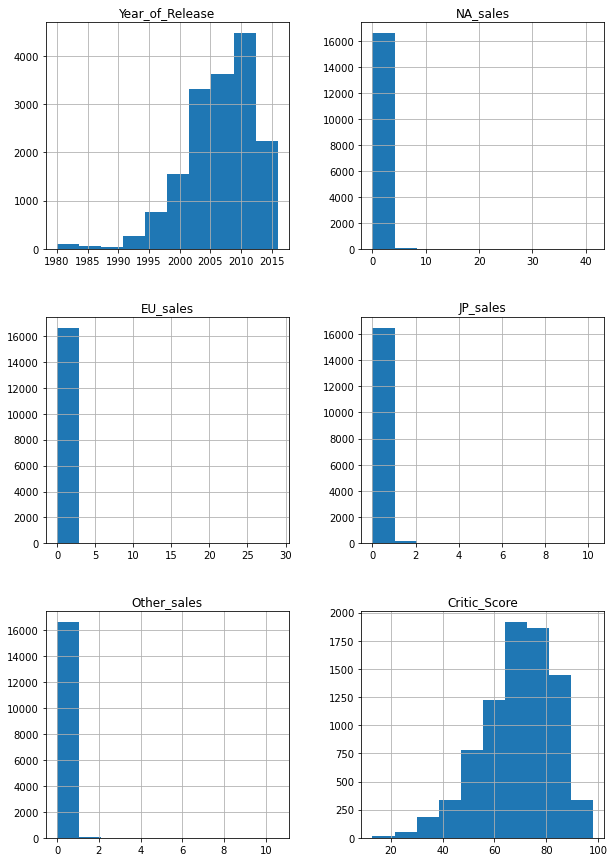

In [4]:
data.hist(figsize=(10, 15));

In [5]:
data.duplicated().sum()

0

**Промежуточное резюме**\
В данных есть некоторые проблемы.\
Названия столбцов в некорректном регистре.\
Есть пропуски в столбцах Name, Year_of_Release, Critic_Score, User_Score, Rating.\
В столбце User_Score некорректный формат - object вместо float, В столбце Year_of_Release формат следует поменять на int либо datetime.\
Critic_score следует привести к формату int.

## Предобработка данных

In [6]:
#приведение названий столбцов к змеиному регистру
data = data.rename(columns = {'Name': 'name',
                              'Platform': 'platform',
                              'Year_of_Release': 'release_year', 
                              'Genre': 'genre',
                             'NA_sales': 'na_sales',
                             'EU_sales': 'eu_sales',
                             'JP_sales': 'jp_sales',
                             'Other_sales': 'other_sales',
                             'Critic_Score': 'critic_score',
                             'User_Score': 'user_score',
                             'Rating': 'rating'})

In [7]:
#посмотрим на 2 строки с пропусками в столбце name
display(data.loc[data['name'].isna() == True])

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
# 2 строки с пропусками в столбце name малоинформативны. Удаляю эти 2 строки
data = data.dropna(subset=['name'])

In [9]:
display(data.loc[data['release_year'].isna() == True].head(10))

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


В строках, где пропущен год релиза, название часто содержит год выхода игры, например FIFA Soccer 2004. В пропусках release_year можно указать эти значения - это будет лучше, чем заполнить пропуски нулем.\
Также некоторые игры, выпущенные на разных платформах, имеют указанный год релиза, но у той же игры на другой платформе год релиза пропущен. В таких пропусках можно указать медиану года релиза этой игры на других платформах.

In [10]:
#для начала заполняю все пропуски нулем
data['release_year'] = data['release_year'].fillna(0)

#ветка try с помощью регулярного выражения ищет в названии игры год и если находит,
#то меняет 0 на год из названия. Ветка except меняет 0 на медианный год релиза этих
#игр на других платформах
try:
    for xxx in data['name'].unique():
        match = re.search(r'\d{4}', xxx)
        criteria_1 = data['name'] == xxx
        criteria_2 = data['release_year'] == 0
        criteria = criteria_1 & criteria_2
        data.loc[criteria, 'release_year'] = match.group(0)
except:
    for xxx in data['name'].unique():
        criteria_1 = data['name'] == xxx
        criteria_2 = data['release_year'] == 0
        criteria = criteria_1 & criteria_2
        data['release_year'] = data['release_year'].fillna(data.query('name == @xxx')['release_year'].median())

In [11]:
#оставшиеся пропуски в release_year удаляем
data = data.query('release_year != 0')

Значение tbd в столбце user_score - вероятно результат какой-то ошибки. Эти значения мешают поменять строковый формат на числовой. Заменяю tbd на 0, затем меняю формат столбца на float.

In [12]:
#заполняем оставшиеся пропуски в других столбцах
data['critic_score'] = data['critic_score'].fillna(0)
data['user_score'] = data['user_score'].str.replace('tbd', '0')
data['user_score'] = data['user_score'].fillna('0')
data['rating'] = data['rating'].fillna('unknown')

In [13]:
# check
data['rating'].value_counts()

unknown    6676
E          3921
T          2905
M          1536
E10+       1393
EC            8
K-A           3
AO            1
RP            1
Name: rating, dtype: int64

In [14]:
#меняю формат данных там, где это нужно
data['release_year'] = data['release_year'].astype('int')
data['user_score'] = pd.to_numeric(data['user_score'])
data['critic_score'] = data['critic_score'].astype('int')

In [15]:
#добавление столбца с общими продажами
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [16]:
#проверка результата предобработки
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16444 non-null  object 
 1   platform      16444 non-null  object 
 2   release_year  16444 non-null  int32  
 3   genre         16444 non-null  object 
 4   na_sales      16444 non-null  float64
 5   eu_sales      16444 non-null  float64
 6   jp_sales      16444 non-null  float64
 7   other_sales   16444 non-null  float64
 8   critic_score  16444 non-null  int32  
 9   user_score    16444 non-null  float64
 10  rating        16444 non-null  object 
 11  all_sales     16444 non-null  float64
dtypes: float64(6), int32(2), object(4)
memory usage: 1.5+ MB


Пропуски убраны, форматы корректны, названия столбцов в змеином регистре.
Можно приступать к анализу данных.

## Исследовательский анализ данных 

### Выпуск игр по годам

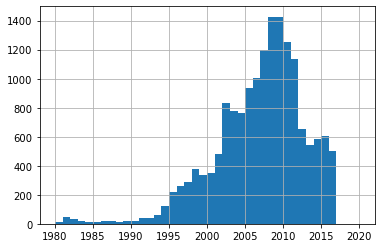

In [17]:
data['release_year'].hist(bins=40, range=(1980, 2020));

На гистограмме видно, что до 1990 года выпускалось незначительное количество игр, этим периодом в исследовании можно пренебречь.

### Платформы с наибольшими суммарными продажами

In [18]:
print(data.groupby('platform')['all_sales'].sum().sort_values(ascending=False))

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: all_sales, dtype: float64


Наибольшие суммарные продажи имеют следующие платформы: PS2, X360, PS3, Wii, DS, PS

### Жизненный цикл платформ

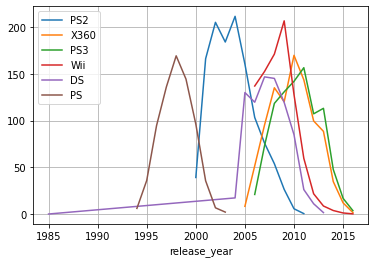

In [19]:
#строю график all_sales по годам по 6 самым популярным платформам
data.query('platform == "PS2"')\
    .groupby('release_year')['all_sales'].sum()\
    .plot(x='release_year', y='all_sales', grid=True, label='PS2', legend=True);

data.query('platform == "X360"')\
    .groupby('release_year')['all_sales'].sum()\
    .plot(x='release_year', y='all_sales', grid=True, label='X360', legend=True);

data.query('platform == "PS3"')\
    .groupby('release_year')['all_sales'].sum()\
    .plot(x='release_year', y='all_sales', grid=True, label='PS3', legend=True);

data.query('platform == "Wii"')\
    .groupby('release_year')['all_sales'].sum()\
    .plot(x='release_year', y='all_sales', grid=True, label='Wii', legend=True);

data.query('platform == "DS"')\
    .groupby('release_year')['all_sales'].sum()\
    .plot(x='release_year', y='all_sales', grid=True, label='DS', legend=True);

data.query('platform == "PS"')\
    .groupby('release_year')['all_sales'].sum()\
    .plot(x='release_year', y='all_sales', grid=True, label='PS', legend=True);

На графике видно, что средний жизненный цикл платформы составляет около 5 лет. Есть странный выброс у платформы DS в 1985 году, хотя приставка начала выпускаться в 2004. Рассмотрим строку с аномалией

In [20]:
display(data.query('release_year == 1985 and platform == "DS"'))

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,0,0.0,unknown,0.02


Такая аномалия всего одна, продажи ее околонулевые, скорее всего это ошибка. Строка не имеет информационной ценности, ее можно спокойно удалить.

In [21]:
data = data.query('name != "Strongest Tokyo University Shogi DS"')

С учетом предыдущего вывода за актуальный период можно принять период с 2014 до 2016 включительно - этот период охватывает чуть меньше 1 среднего жизненного цикла платформы

### Выбор наиболее потенциальных платформ

In [22]:
data_actual = data.query('release_year >= 2014')
print(data_actual.groupby('platform')['all_sales'].sum().sort_values(ascending=False))

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: all_sales, dtype: float64


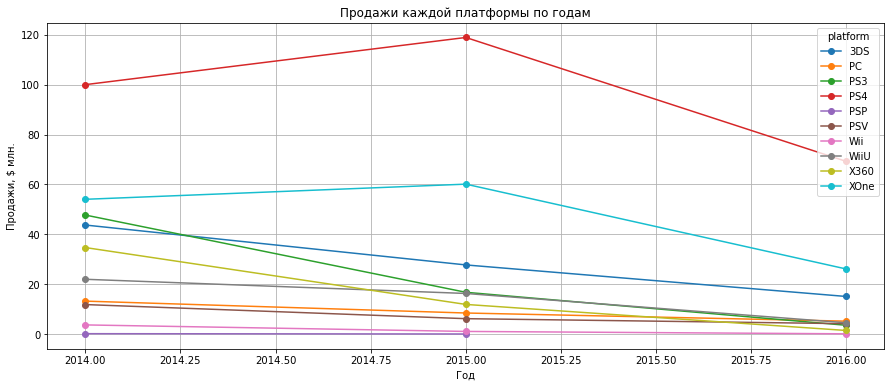

In [23]:
# check

(data_actual
   .pivot_table(index='release_year', columns='platform', values='all_sales', aggfunc='sum')
   .plot(style='o-', grid= True, legend=True, figsize=(15,6))
   .set(xlabel='Год', ylabel='Продажи, $ млн.', title='Продажи каждой платформы по годам')
);

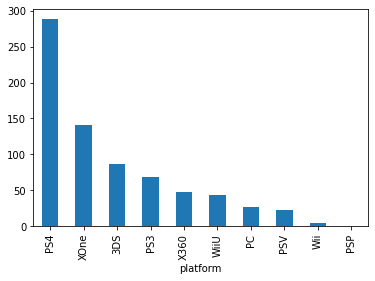

In [24]:
data_actual.groupby('platform')['all_sales'].sum().sort_values(ascending=False).plot(kind='bar');

Судя по тому, что продажи всех платформ резко падают в 2016, либо это был кризисный год для индустрии, либо данные за 2016 в датасете не полные.\
Если не брать во внимание аномально низкий 2016 год, то можно выделить единстенные 2 растущие платформы в актуальном периоде:\
**PS4**\
**XOne**\
\
**PS3**, **3DS** и **X360** имеют также крупные объемы продаж за выбранный период, но к 2016 находятся на стадии завершения своего жизненного цикла, поэтому эти платформы не стал бы рассматривать как перспективные.

### Разброс данных по продажам разных платформ

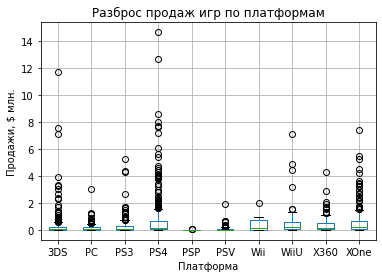

In [52]:
#построение графика "ящик с усами" по платформам
data_actual.pivot_table(index='name', columns='platform', values='all_sales', aggfunc='sum')\
    .boxplot()\
    .set(xlabel='Платформа', ylabel='Продажи, $ млн.', title='Разброс продаж игр по платформам');

Выюросы мешают сделать однозначные выводы. Пока явными аутсайдерами среди платформ выглядят PSP, PSV. Наиболее интересные платформы - PS4, Wii, WiiU, X360, XOne. Увеличим масштаб графика

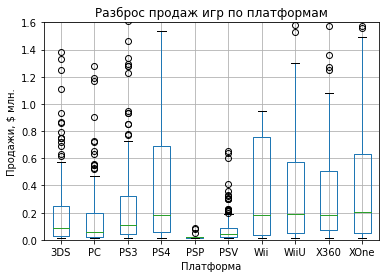

In [53]:
data_actual.pivot_table(index='name', columns='platform', values='all_sales', aggfunc='sum')\
    .boxplot()\
    .set(xlabel='Платформа', ylabel='Продажи, $ млн.', title='Разброс продаж игр по платформам')
plt.ylim(0, 1.6);

Наивысшую медиану и 3 квартиль имеет платформа XBox One, далее следуют PS4, XBox 360, Wii, WiiU - эти платформы имеют наибольшее кол-во коммерчески успешных игр.

### Зависимость продаж от оценок 

Коэффициент корреляции 0.44657460493190715


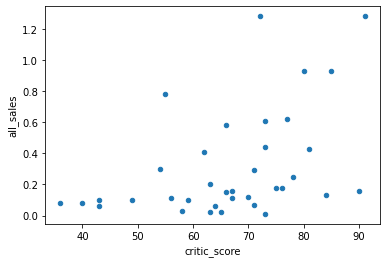

In [27]:
#зависимость оценки критиков на глобальные продажи
data_ps3_pivot = data_actual.query('platform == "PS3" and critic_score != 0')\
    .pivot_table(index='name', values=['all_sales', 'critic_score', 'user_score'], aggfunc='sum')
data_ps3_pivot.plot(x='critic_score', y='all_sales', kind='scatter')

print('Коэффициент корреляции', data_ps3_pivot['critic_score'].corr(data_ps3_pivot['all_sales']))

Коэффициент корреляции 0.1565951618135996


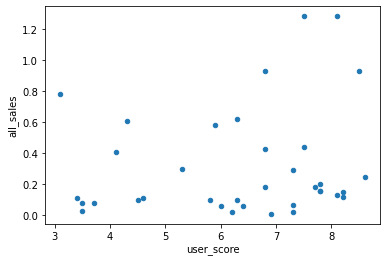

In [28]:
#зависимость оценки пользователей на глобальные продажи
data_ps3_pivot_2 = data_actual.query('platform == "PS3" and user_score != 0')\
    .pivot_table(index='name', values=['all_sales', 'critic_score', 'user_score'], aggfunc='sum')
data_ps3_pivot.plot(x='user_score', y='all_sales', kind='scatter')

print('Коэффициент корреляции', data_ps3_pivot['user_score'].corr(data_ps3_pivot['all_sales']))

Можно сделать вывод, что оценки пользователей практически не влияют на глобальные продажи игр, что подтверждается низким коэффициентом корреляции. Оценки критиков, напротив, значительно влияют на продажи игр - не все игры с высоким рейтингом имеют большие продажи, но все бестселлеры имеют высокий рейтинг от 65 и выше.

Коэффициент корреляции 0.5257228356581521


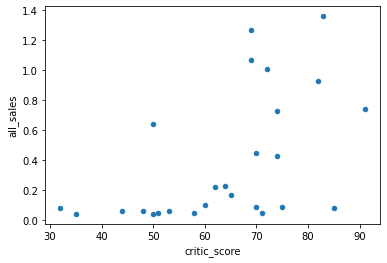

In [29]:
#проверка вывода на двух других платформах
data_x360_pivot = data_actual.query('platform == "X360" and critic_score != 0')\
    .pivot_table(index='name', values=['all_sales', 'critic_score', 'user_score'], aggfunc='sum')
data_x360_pivot.plot(x='critic_score', y='all_sales', kind='scatter')

print('Коэффициент корреляции', data_x360_pivot['critic_score'].corr(data_x360_pivot['all_sales']))

Коэффициент корреляции 0.3365136248359933


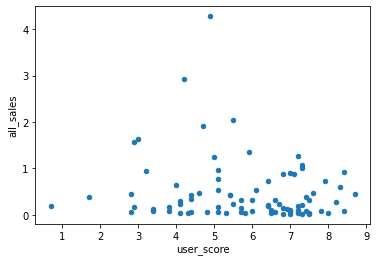

In [30]:
data_x360_pivot_2 = data_actual.query('platform == "X360" and user_score != 0')\
    .pivot_table(index='name', values=['all_sales', 'critic_score', 'user_score'], aggfunc='sum')
data_x360_pivot_2.plot(x='user_score', y='all_sales', kind='scatter')

print('Коэффициент корреляции', data_x360_pivot['user_score'].corr(data_x360_pivot['all_sales']))

Коэффициент корреляции 0.4026614106810412


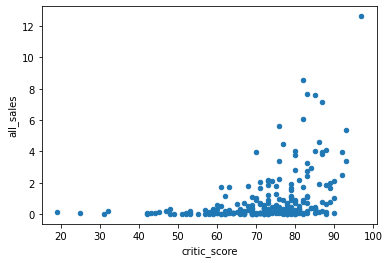

In [31]:
data_ps4_pivot = data_actual.query('platform == "PS4" and critic_score != 0')\
    .pivot_table(index='name', values=['all_sales', 'critic_score', 'user_score'], aggfunc='sum')
data_ps4_pivot.plot(x='critic_score', y='all_sales', kind='scatter')

print('Коэффициент корреляции', data_ps4_pivot['critic_score'].corr(data_ps4_pivot['all_sales']))

Коэффициент корреляции -0.009372274681362508


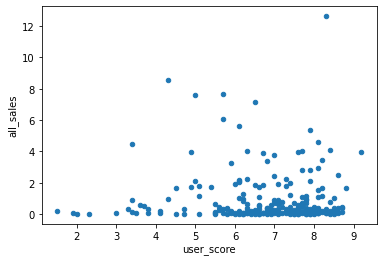

In [32]:
data_ps4_pivot_2 = data_actual.query('platform == "PS4" and user_score != 0')\
    .pivot_table(index='name', values=['all_sales', 'critic_score', 'user_score'], aggfunc='sum')
data_ps4_pivot_2.plot(x='user_score', y='all_sales', kind='scatter')

print('Коэффициент корреляции', data_ps4_pivot['user_score'].corr(data_ps4_pivot['all_sales']))

Вывод подтвердился - у всех ТОП-3 платформ оценка пользователей не влияет на глобальные продажи. Есть корреляция между оценкой критиков и глобальными продажами, но она слаба, и имеющиеся данные не позволяют сделать однозначный вывод о том, какой фактор на какой влияет - возможно, высокие оценки критиков повышают вероятность коммерческого успеха игры, а возможно критики склонны ставить более высокие оценки бестселлерам.

###  Исследование жанров

genre
Action          199.36
Shooter         170.94
Sports          109.48
Role-Playing    101.44
Misc             37.55
Fighting         28.22
Racing           27.52
Platform         18.09
Adventure        17.55
Simulation       13.13
Strategy          3.96
Puzzle            2.21
Name: all_sales, dtype: float64

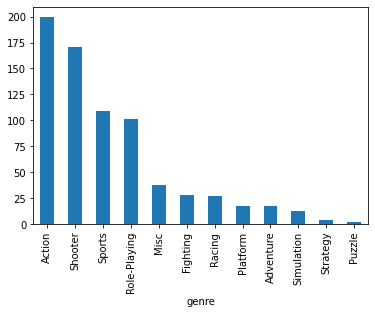

In [33]:
sales_by_genre = data_actual.groupby('genre')['all_sales'].sum().sort_values(ascending=False)
display(sales_by_genre)
sales_by_genre.plot(kind='bar');

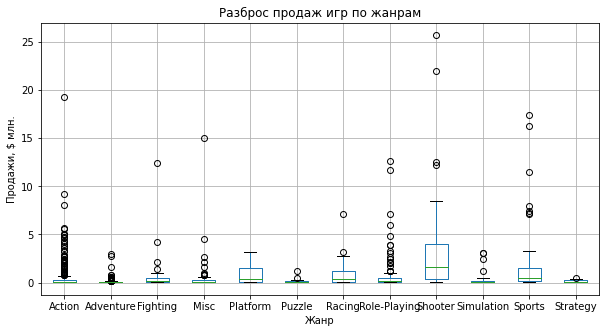

In [34]:
data_actual.pivot_table(index='name', columns='genre', values='all_sales', aggfunc='sum')\
    .boxplot(figsize=(10, 5))\
    .set(xlabel='Жанр', ylabel='Продажи, $ млн.', title='Разброс продаж игр по жанрам');

Выбросы мешают оценить разброс продаж по жанрам. Увеличим масштаб

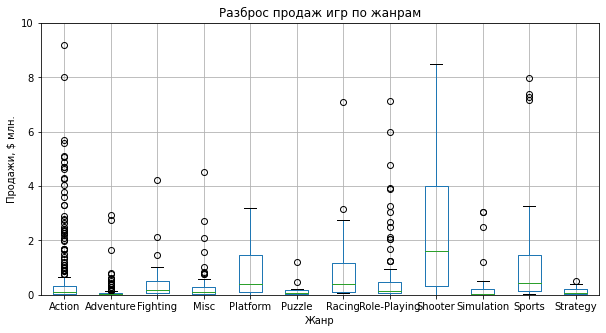

In [35]:
data_actual.pivot_table(index='name', columns='genre', values='all_sales', aggfunc='sum')\
    .boxplot(figsize=(10, 5))\
    .set(xlabel='Жанр', ylabel='Продажи, $ млн.', title='Разброс продаж игр по жанрам')
plt.ylim(0, 10);

Самые продаваемые жанры игр - Action, Shooter, с некоторым отставанием Sports, Role-Playing. Аутсайдеры по объемам продаж - Puzzle, Strategy, Simulation.\
Но результат Action достигнут засчет небольшого числа игр с аномально высокими продажами. Если брать во внимание стабильность результатов, то безоговорочным лидером выглядят шутеры - в этом жанре самая высокая медиана и наибольшее относительное количество коммерчески успешных игр. Далее по этому показателю следуют с почти одинаковыми результатами идут жанры Platform, Racing, Sports.

## Портрет пользователя по регионам 

### Региональные предпочтения платформ 

#### Регион NA (Северная Америка) 

In [36]:
#ТОП-5 платформ по продажам
na_sales_platform = data_actual.groupby('platform')\
    .agg({'na_sales': 'sum'}).sort_values(by='na_sales', ascending=False)

na_sales_platform['share'] = na_sales_platform['na_sales'] / na_sales_platform['na_sales'].sum()
display(na_sales_platform.head(5))
display(f'Доля ТОП-5 платформ на рынке: {na_sales_platform.head(5)["share"].sum()}')

,na_sales,share
platform,,
PS4,98.61,0.347145
XOne,81.27,0.286102
X360,28.30,0.099627
3DS,22.64,0.079701
PS3,22.05,0.077624


'Доля ТОП-5 платформ на рынке: 0.8901992536788003'

С большим отрывом лидируют PS4 и XBox One, имея на двоих более половины рынка. Высокие показатели XOne, судя по всему, обусловлены тем, что это детище американской Microsoft. Далее следуют с почти равными долями платформы X360, 3DS и PS3.

#### Регион EU (Европа)

In [37]:
#ТОП-5 платформ по продажам
eu_sales_platform = data_actual.groupby('platform')\
    .agg({'eu_sales': 'sum'}).sort_values(by='eu_sales', ascending=False)

eu_sales_platform['share'] = eu_sales_platform['eu_sales'] / eu_sales_platform['eu_sales'].sum()
display(eu_sales_platform.head(5))
display(f'Доля ТОП-5 платформ на рынке: {eu_sales_platform.head(5)["share"].sum()}')

,eu_sales,share
platform,,
PS4,130.04,0.480420
XOne,46.25,0.170866
PS3,25.54,0.094355
PC,17.97,0.066388
3DS,16.12,0.059554


'Доля ТОП-5 платформ на рынке: 0.8715826806561254'

Лидеры те же, что в Северной Америке -  PS4, XOne. Далее идут PS3 и другие платформы.

#### Регион JP (Япония)

In [38]:
#ТОП-5 платформ по продажам
jp_sales_platform = data_actual.groupby('platform')\
    .agg({'jp_sales': 'sum'}).sort_values(by='jp_sales', ascending=False)

jp_sales_platform['share'] = jp_sales_platform['jp_sales'] / jp_sales_platform['jp_sales'].sum()
display(jp_sales_platform.head(5))
display(f'Доля ТОП-5 платформ на рынке: {jp_sales_platform.head(5)["share"].sum()}')

,jp_sales,share
platform,,
3DS,44.24,0.475239
PS4,15.02,0.161349
PSV,14.54,0.156193
PS3,11.22,0.120529
WiiU,7.31,0.078526


'Доля ТОП-5 платформ на рынке: 0.9918358577720486'

Картина разительно отличается от Европы и Америки. С большим отрывом лидирует Nintendo 3DS, далее следуют разные вариации PS. Потребители в Японии не лишены потребительского патриотизма - предпочитают отечественные платформы.

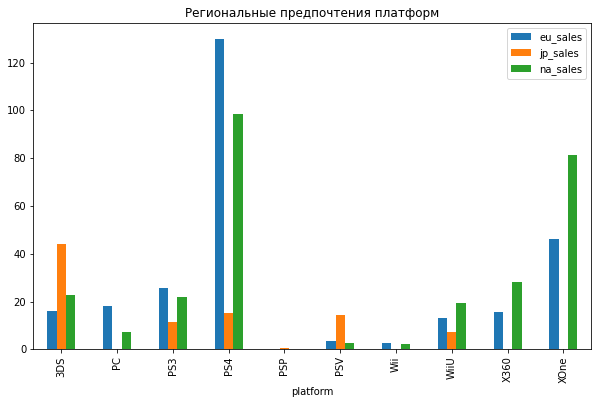

In [39]:
platform_by_region = data_actual.pivot_table(
    index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
platform_by_region.plot(kind='bar', title='Региональные предпочтения платформ', figsize=(10, 6));

### Региональные предпочтения по жанрам

#### Регион NA (Сев. Америка) 

In [40]:
#ТОП-5 жанров по продажам
na_sales_genre = data_actual.groupby('genre')\
    .agg({'na_sales': 'sum'}).sort_values(by='na_sales', ascending=False)

na_sales_genre['share'] = na_sales_genre['na_sales'] / na_sales_genre['na_sales'].sum()
display(na_sales_genre.head(5))
display(f'Доля ТОП-5 жанров на рынке: {na_sales_genre.head(5)["share"].sum()}')

,na_sales,share
genre,,
Shooter,79.02,0.278181
Action,72.53,0.255333
Sports,46.13,0.162395
Role-Playing,33.47,0.117827
Misc,15.05,0.052982


'Доля ТОП-5 жанров на рынке: 0.8667182989509258'

Предпочтения рынка отчетливо видны: шутеры и экшны на двоих занимают больше половины рынка Северной Америки. Далее по поулярности за ними следуют жанры Sports, Role-Playing, Misc.
Всего ТОП-5 жанров занимают 87% этого рынка.

#### Регион EU (Европа) 

In [41]:
#ТОП-5 жанров по продажам
eu_sales_genre = data_actual.groupby('genre')\
    .agg({'eu_sales': 'sum'}).sort_values(by='eu_sales', ascending=False)

eu_sales_genre['share'] = eu_sales_genre['eu_sales'] / eu_sales_genre['eu_sales'].sum()
display(eu_sales_genre.head(5))
display(f'Доля ТОП-5 жанров на рынке: {eu_sales_genre.head(5)["share"].sum()}')

,eu_sales,share
genre,,
Action,74.68,0.275898
Shooter,65.52,0.242057
Sports,45.73,0.168945
Role-Playing,28.17,0.104071
Racing,14.13,0.052202


'Доля ТОП-5 жанров на рынке: 0.843172750110832'

Предпочтения европейских потребителей максимально близки к таковым в Сев. Америке.

#### Регион JP (Япония)

In [42]:
#ТОП-5 жанров по продажам
jp_sales_genre = data_actual.groupby('genre')\
    .agg({'jp_sales': 'sum'}).sort_values(by='jp_sales', ascending=False)

jp_sales_genre['share'] = jp_sales_genre['jp_sales'] / jp_sales_genre['jp_sales'].sum()
display(jp_sales_genre.head(5))
display(f'Доля ТОП-5 жанров на рынке: {jp_sales_genre.head(5)["share"].sum()}')

,jp_sales,share
genre,,
Role-Playing,31.16,0.334730
Action,29.58,0.317757
Fighting,6.37,0.068428
Misc,5.61,0.060264
Shooter,4.87,0.052315


'Доля ТОП-5 жанров на рынке: 0.8334944677194114'

Япония сильно отличается от западных рынков - в отличие от них, здесь наибольшей популярностью пользуютя ролевые игры. Для большей наглядности выведем данные на один график:

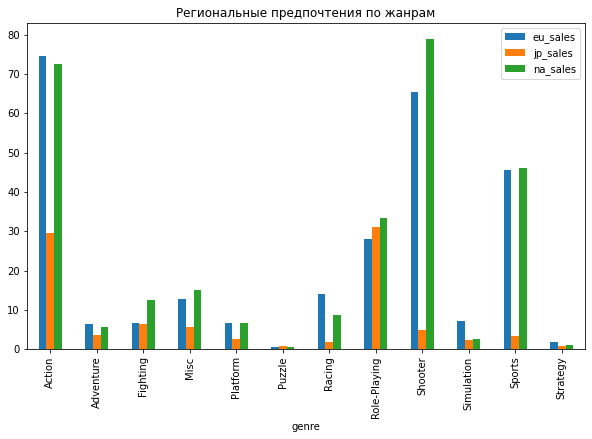

In [43]:
genre_by_region = data_actual.pivot_table(
    index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
genre_by_region.plot(kind='bar', title='Региональные предпочтения по жанрам', figsize=(10, 6));

Экшны и ролевые игры любят везде, особенно в Японии. Западные рынки, помимо этого, предпочитают шутеры и спортивные игры.

### Региональные предпочтения по рейтингу ESRB 

#### Регион NA (Сев. Америка)

In [44]:
na_sales_rating = data_actual.groupby('rating')\
    .agg({'na_sales': 'sum'}).sort_values(by='na_sales', ascending=False)
display(na_sales_rating)

,na_sales
rating,
M,96.42
unknown,64.72
E,50.74
T,38.95
E10+,33.23


Наибольшие продажи на этом рынке имеют игры категорий М (от 17 лет) и Е (от 6 лет). Примерно равные доли у категорий Т (от 13 лет) и Е10+ (от 10 лет). Стоит учитывать, что в группу unknown с неопределенным рейтингом попала значительная часть игр, которая могла бы изменить расстановку в данной таблице.

#### Регион EU (Европа) 

In [45]:
eu_sales_rating = data_actual.groupby('rating')\
    .agg({'eu_sales': 'sum'}).sort_values(by='eu_sales', ascending=False)
display(eu_sales_rating)

,eu_sales
rating,
M,93.44
unknown,58.95
E,58.06
T,34.07
E10+,26.16


Распределение продаж по рейтингу ESRB практически не отличается от такового на рынке Америки.

#### Регион JP (Япония) 

In [46]:
jp_sales_rating = data_actual.groupby('rating')\
    .agg({'jp_sales': 'sum'}).sort_values(by='jp_sales', ascending=False)
display(jp_sales_rating)

,jp_sales
rating,
unknown,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


Наиболее продаваемые в Японии игры имеют пропуск в рейтинге ESRB. Возможно, это локальные азиатские игры, которые в принципе не имеют этого рейтинга за ненадобностью. Среди игр с заполненной категорией самые продаваемые имеют рейтинг Е (от 6 лет), Т (от 13), М (от 17).

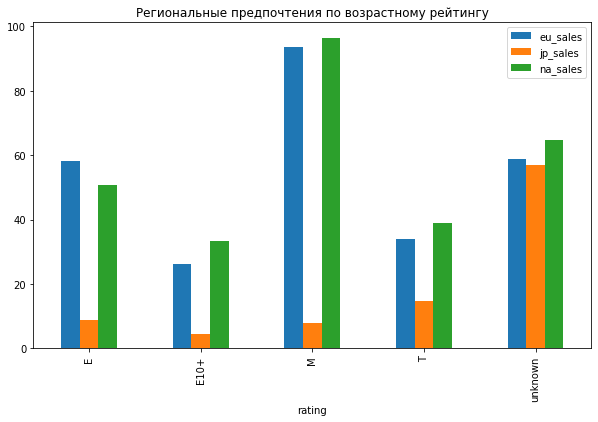

In [47]:
rating_by_region = data_actual.pivot_table(
    index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
rating_by_region.plot(kind='bar', title='Региональные предпочтения по возрастному рейтингу', figsize=(10, 6));

На графике близость рынков Европы и Америки особенно наглядна. Также видно, что наиболее популярные в Японии игры не имеют рейтинга ESRB, и скорее всего, не представлены на западных рынках.

## Проверка гипотез 

Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Она же нулевая гипотеза. Таким образом альтернативная гипотеза будет звучать так:\
Средние пользовательские рейтинги платформ Xbox One и PC неодинаковые.

In [48]:
#Предположим, что наш датасет - это генеральная совокупность и сравним среднюю оценку
#обеих платформ и их стандартное отклонение

print(data_actual.query('platform == "XOne" and user_score != 0')['user_score'].describe())
print(data_actual.query('platform == "PC" and user_score != 0')['user_score'].describe())

count    165.000000
mean       6.594545
std        1.375139
min        1.600000
25%        5.800000
50%        6.800000
75%        7.600000
max        9.200000
Name: user_score, dtype: float64
count    122.000000
mean       6.298361
std        1.703278
min        1.400000
25%        5.325000
50%        6.800000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64


Средние оценки пользователей двух платформ близки, но не настолько, чтобы считать их одинаковыми - \
4.8 у XOne\
5.1 у PC\
Значения стандартный отклонений и медиан у двух платформ также близки, но не одинаковы.
Теперь предположим, что data - это выборка из генеральной совокупности и проведем статистический тест для проверки гипотезы.

In [49]:
results_platform = st.ttest_ind(
    data_actual.query('platform == "XOne" and user_score != 0')['user_score'],
    data_actual.query('platform == "PC"and user_score != 0')['user_score']
)

alpha = .05

print('p-значение:', results_platform.pvalue)

if results_platform.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


Для имеющихся выборок существует 10%-ая вероятность того, что нулевая гипотеза верна, т.е. средние оценки пользователей Xbox One и PC одинаковы. Это статистически значимый результат, а значит нулевую гипотезу нельзя отвергнуть.

Гипотеза 2 (нулевая гипотеза): Средние пользовательские рейтинги жанров Action и Sports одинаковые. Альтернативная гипотеза:\
Средние пользовательские рейтинги жанров Action и Sports не одинаковые.

In [50]:
#для начала просто сравним среднюю оценку по жанрам и их стандартное отклонение

print(data_actual.query('genre == "Action" and user_score != 0')['user_score'].describe())
print(data_actual.query('genre == "Sports" and user_score != 0')['user_score'].describe())

count    297.000000
mean       6.760606
std        1.377852
min        2.000000
25%        6.100000
50%        7.100000
75%        7.700000
max        9.000000
Name: user_score, dtype: float64
count    127.000000
mean       5.225197
std        1.856604
min        0.200000
25%        4.000000
50%        5.500000
75%        6.650000
max        8.800000
Name: user_score, dtype: float64


Опять по таким данным сложно сделать однозначный вывод.\
Средняя оценка в жанре Action выше, чем у Sports - 6.76 против 5.22, но у Action выше и стандартное отклонение, поэтому здесь не обойтись без статистического теста.\
Выборки значительно различаются по объему: 297 / 127 результатов. Для теста укажем equal_var=False

In [51]:
results_genre = st.ttest_ind(data_actual.query('genre == "Action" and user_score != 0')['user_score'],
    data_actual.query('genre == "Sports" and user_score != 0')['user_score'],
    equal_var=False)

alpha = .05

print('p-значение:', results_genre.pvalue)

if results_genre.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Средние пользовательские рейтинги жанров Action и Sports с крайне высокой вероятностью различаются. Крайне низкий показатель pvalue дает весомый повод отвергнуть гипотезу "Средние пользовательские рейтинги жанров Action и Sports одинаковые" 

## Общий вывод 

Из полученного датасета можно сделать несколько выводов:
1) Бум игровой индустрии начался в 90-е годы, когда кол-во выпускаемых игр бурно росло с каждым годом, достигнув пика в 2010 году.\
2) Наиболее популярные платформы по общим продажам PS2, X360, PS3, Wii, DS, PS.\
3) Средний жизненный цикл платформы составляет 5 лет.\
4) Наиболее перспективные платформы по состоянию на 2016 год - **PS4** и **Xbox One**\
5) Продажи игр слабо коррелируют с оценкой критиков, но по имеющимся данным нельзя сделать вывод - оценка влиает на продажи или наоборот. При этом оценки пользователей на объем продаж почти не влияют.\
6) Самые продаваемые жанры игр - Action, Shooter. Аутсайдеры по объемам продаж - Puzzle, Strategy, Adventure.

Предпочтения потребителей в Северной Америке и Европе очень близки, но от них обоих сильно отличается рынок Японии.\

1) Потребители Америки и Японии склонны к патриотизму в выборе платформ - в Сев. Америке лидирует PS4, на втором месте Xbox One, в Японии безоговорочный лидер 3DS, далее следуют разные вариации платформ от Sony. В Европе предпочтения платформ максимально близки к американским.\
2) Жанровые предпочтения рынков Америки и Европы также одинаковые - на обоих рынках лидируют экшн, шутеры и спортивные игры. В Японии лидируют ролевые игры и только на 2-м месте экшн-игры.\
3) По рейтингу ESRB предпочтения игроков Сев. Америки и Европы также одинаковы - на этих рынках лидируют игры категорий М (от 17 лет) и Е (от 6 лет). Японский рынок, не обремененный требованием иметь рейтинг ESRB, не поддается анализу с этой точки зрения.\

Статистически были проверены 2 гипотезы:\
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.\
2. Средние пользовательские рейтинги жанров Action и Sports одинаковые.\

Вероятность равенства двух выборок в первой гипотезе выше порога статистической значимости, поэтому она не может быть отвергнута.\
Крайне низкое значение pvalue в для гипотезы №2 говорит, позволяет отвергнуть гипотезу и констатировать с очень высокой вероятностью, что средние пользовательские рейтинги жанров Action и Sports различаются между собой.